# PCA

#### 預處理Function

In [2]:
from __future__ import division
import codecs, numpy
from textblob import TextBlob  #情感分類
import math


def build_word_vector_matrix(vector_file, n_words):
  '''Return the vectors and labels for the first n_words in vector file'''
  numpy_arrays = []
  labels_array = []
  with codecs.open(vector_file, 'r', 'utf-8') as f:
    for c, r in enumerate(f):
      sr = r.split()
      labels_array.append(sr[0])
      numpy_arrays.append( numpy.array([float(i) for i in sr[1:]]) )

      if c == n_words:
        return numpy.array( numpy_arrays ), labels_array

  return numpy.array( numpy_arrays ), labels_array

def poparity(a):         #回傳情感值 [-1,1],1表好,-1表差
    blob=TextBlob(a)
    return blob.polarity

def preprocessing(df,words): #回傳情感非0的那些單字與向量,好的為1,差的為0,
    label=[]
    data=[]
    word=[]
    for i in range(len(words)):
        if (poparity(words[i])!=0):
            a=poparity(words[i])
            data.append(df[i])
            word.append(labels_array[i])
            if a==-1:
                label.append(0)
            else:
                label.append(math.ceil(a))
    return word,data,label

#### 從10000個單字中取出帶有情感的單字

In [3]:
input_vector_file = 'glove.6B.300d.txt' # Vector file input (e.g. glove.6B.300d.txt)
df, labels_array = build_word_vector_matrix(input_vector_file, 10000)
w,d,l=preprocessing(df,labels_array) # w為帶有情感的單字 , d 代表該單字的向量 , l 代表帶有的情感

#### 將資料用PCA降維 ,映射在2維平面上 ,觀察可知有些部分是重疊的

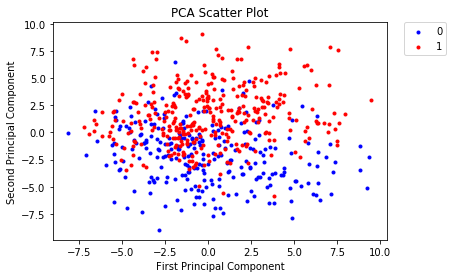

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import numpy as np
pca = PCA(n_components=2)
d=scale(d)                      #資料正規化 平均為1 標準差為1
vector=pca.fit_transform(d)     #將資料映射到二維平面

colors = ['blue',  'red']       #0為藍點 , 1為紅點
for i in range(len(colors)):
    x = vector[:, 0][np.array(l) == i]
    y = vector[:, 1][np.array(l) == i]
    plt.scatter(x, y, c=colors[i],marker='.')
    
plt.legend(range(len(colors)), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("PCA Scatter Plot")
plt.show()

# SVM

#### 將資料分割成訓練資料與驗證資料

In [5]:
# Import `train_test_split`
from sklearn.cross_validation import train_test_split
# Split the `digits` data into training and test sets
X_train, X_test, y_train, y_test =train_test_split(d, l , test_size=0.2, random_state=42)

C:\Users\baker\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### 隨便帶一組參數進去SVM看看結果 ,準確率為80%

In [6]:
# Import the `svm` model
from sklearn import svm
# Create the SVC model 
svc_model = svm.SVC(gamma=0.001, C=100., kernel='linear')
# Fit the data to the SVC model
svc_model.fit(X_train, y_train)
# Apply the classifier to the test data, and view the accuracy score
svc_model.score(X_test,y_test)

0.80991735537190079

#### 使用網格搜尋法找出SVM的較佳參數

In [7]:
# Import GridSearchCV
from sklearn.grid_search import GridSearchCV

# Set the parameter candidates
parameter_candidates = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

# Create a classifier with the parameter candidates
clf = GridSearchCV(estimator=svm.SVC(), param_grid=parameter_candidates, n_jobs=-1)

# Train the classifier on training data
clf.fit(X_train, y_train)
# Print out the results 
print('Best score for training data:', clf.best_score_)
print('Best `C`:',clf.best_estimator_.C)
print('Best kernel:',clf.best_estimator_.kernel)
print('Best `gamma`:',clf.best_estimator_.gamma)

C:\Users\baker\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Best score for training data: 0.8045738045738046
Best `C`: 1
Best kernel: rbf
Best `gamma`: 0.001


#### 調整參數後準確率為86%

In [8]:
clf.score(X_test, y_test) 

0.85950413223140498

#### 手動輸入搜尋出的參數 ,重設 SVM 參數

In [9]:
# Train and score a new classifier with the grid search parameters
svc_model =svm.SVC(C=1, kernel='rbf', gamma=0.001)
svc_model.fit(X_train, y_train)
svc_model.score(X_test,y_test)

0.85950413223140498

#### 建立classification_report & confusion_matrix ,觀察判斷錯的情況較多為喜悅誤判為悲傷 ,共11筆 

In [10]:
# Import `metrics`
from sklearn import metrics

predicted=svc_model.predict(X_test)

# Print the classification report of `y_test` and `predicted`
print(metrics.classification_report(y_test, predicted))

# Print the confusion matrix
print(metrics.confusion_matrix(y_test, predicted))

             precision    recall  f1-score   support

          0       0.90      0.79      0.84        57
          1       0.83      0.92      0.87        64

avg / total       0.86      0.86      0.86       121

[[45 12]
 [ 5 59]]
